In [1]:
NETS = ['dilation', 'crossing', 'multi_lstm_init','lstm', 'unet']
import tensorflow as tf
import datasets
import pickle
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import itertools
import seaborn as sns

In [2]:


results_data = []
for NET in NETS:
    if NET == 'dilation':
        import experiments.dilation as experiments
    elif NET == 'segnet':
        import experiments.segnet as experiments
    elif NET == 'lstm':
        import experiments.lstm as experiments
    elif NET == 'coloring':
        import experiments.coloring as experiments
    elif NET == 'crossing':
        import experiments.crossing as experiments
    elif NET == 'unet':
        import experiments.unet as experiments
    elif NET == 'multi_lstm':
        import experiments.multi_lstm as experiments
    elif NET == 'multi_lstm_init':
        import experiments.multi_lstm_init as experiments
    elif NET == 'FF':
        import experiments.FF as experiments
    elif NET == 'optimal_lstm':
        import experiments.optimal_lstm as experiments

    output_path = '/om/user/xboix/share/insideness/' + NET + '/'
    run_opt = experiments.get_experiments(output_path)[1:]
    print(len(run_opt))

    results_data.append([])
    for opt in run_opt:
        if not opt.skip:
            data_point = {}
            
            if opt.dataset.complexity>4:
                continue
            if NET == 'multi_lstm_init':
                opt.dataset.complexity_strict = True
                
            if opt.dataset.complexity_strict == False:
                continue
                
            data_point["dataset_complexity"] = opt.dataset.complexity
            data_point["dataset_strict_complexity"] = opt.dataset.complexity_strict
            if opt.dataset.image_size == 80:
                data_point["dataset_complexity"] = 6 

            if not os.path.isfile(opt.log_dir_base + opt.name + '/results/intra_dataset_accuracy.pkl'):
                data_point["results"] = "empty"

            else:
                with open(opt.log_dir_base + opt.name + '/results/intra_dataset_accuracy.pkl', 'rb') as f:
                    data_point["results"] = pickle.load(f)

            results_data[-1].append(copy.deepcopy(data_point))

8102
8100
270
1782
3241
3288


In [3]:
NUM_COMPLEXITIES = 5
max_train = []
max_test = []
max_train_loose = []
max_test_loose = []
for idx_net, NET in enumerate(NETS):
    
    max_val_acc = -np.ones([2, NUM_COMPLEXITIES])
    max_idx = np.zeros([2, NUM_COMPLEXITIES])
    missing = np.zeros([2, NUM_COMPLEXITIES])
    
    for point_idx, data_point in enumerate(results_data[idx_net]):

        point_complextity = data_point["dataset_complexity"]
        idx_strict = 1-int(data_point["dataset_strict_complexity"])

        #if (not ("val" in data_point["results"])):
        #    print(point_idx)

        if not (data_point["results"] == "empty") and ("val" in data_point["results"]): 

                if max_val_acc[idx_strict, point_complextity] < data_point["results"]["valloose"]:
                    max_idx[idx_strict, point_complextity] = point_idx
                    max_val_acc[idx_strict, point_complextity] = data_point["results"]["valloose"]

        else:
            missing[idx_strict, point_complextity] += 1
    print(max_idx)
    
    max_train.append(np.zeros([2, NUM_COMPLEXITIES]))
    max_test.append(np.zeros([2, NUM_COMPLEXITIES]))
    max_train_loose.append(np.zeros([2, NUM_COMPLEXITIES]))
    max_test_loose.append(np.zeros([2, NUM_COMPLEXITIES]))


    for idx_strict, dataset_strict_complexity  in enumerate([True, False]):
        for dataset_complexity in range(NUM_COMPLEXITIES):
            #if  results_data[int(max_idx[idx_strict,dataset_complexity])]["results"]=="empty":
            #    continue
            max_train[-1][idx_strict, dataset_complexity] = \
                results_data[idx_net][int(max_idx[idx_strict,dataset_complexity])]["results"]["train"]
            max_test[-1][idx_strict, dataset_complexity] = \
                results_data[idx_net][int(max_idx[idx_strict,dataset_complexity])]["results"]["test"]
            max_train_loose[-1][idx_strict, dataset_complexity] = \
                results_data[idx_net][int(max_idx[idx_strict,dataset_complexity])]["results"]["trainloose"]
            max_test_loose[-1][idx_strict, dataset_complexity] = \
                results_data[idx_net][int(max_idx[idx_strict,dataset_complexity])]["results"]["testloose"]

            
        

[[ 145.  625.  721. 1165. 1477.]
 [   0.    0.    0.    0.    0.]]
[[ 165. 1100. 1839. 3206. 3997.]
 [   0.    0.    0.    0.    0.]]
[[ 13.  67.  97. 120. 175.]
 [  0.   0.   0.   0.   0.]]
[[ 97. 182. 452. 615. 746.]
 [  0.   0.   0.   0.   0.]]
[[ 73. 422. 643. 829. 925.]
 [  0.   0.   0.   0.   0.]]


[99.98000168 99.9410576  99.95053048 99.84843382 99.27479791]
[6.68712108e+01 9.91106012e+01 5.87971539e+01 0.00000000e+00
 5.15746042e-02]
[100.          99.91158639  99.97899866  99.89895588  99.80843718]
[100.          99.95053048  99.97894914  99.93263725  99.87895756]
[99.9905494  97.06656282 93.99103233 91.73017009 66.82627688]
[99.99989197 99.99996615 99.99993829 99.99984729 99.99866073]
[99.87659608 99.98672685 99.48998035 94.96255589 94.37497296]
[100.          99.99994853  99.99998798  99.99991805  99.99926625]
[100.          99.99996321  99.99998651  99.99935731  99.99984715]
[99.99998829 99.99717037 99.99259192 99.98673734 99.93206857]


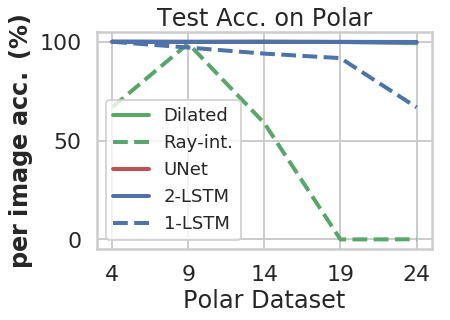

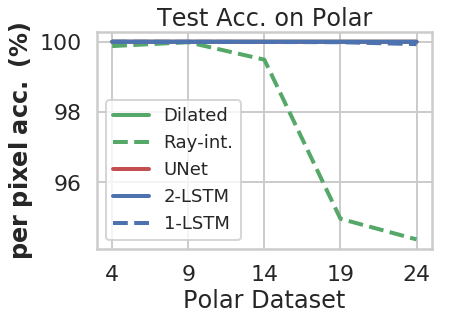

In [4]:
import seaborn

seaborn.set()
seaborn.set_style("whitegrid")
seaborn.set_context("poster")
def plot_results_train_test(train, title, fig, name,c):

    x = np.linspace(1,5, NUM_COMPLEXITIES)
    xlabels = ['4','9','14','19','24' ]
    ytext =r'$\bf per$ $\bf pixel$ $\bf acc.$ $\bf(\%)$'

    plt.figure(fig)
    print(train)
    plt.plot(x, train, c,label=name, linewidth=4)
    plt.ylabel(ytext)
    plt.xlabel('Polar Dataset')
    plt.title('Test Acc. on Polar')
    plt.xticks(x, xlabels)
    leg = plt.legend(loc='lower left', ncol=1,  fancybox=True, prop={'size': 18})
    plt.savefig('./fig/quantitative/1.pdf', format='pdf',  bbox_inches='tight', dpi=1000)

def plot_results_train_test_image(train, title, fig, name,c):

    x = np.linspace(1,5, NUM_COMPLEXITIES)
    xlabels = ['4','9','14','19','24' ]
    ytext =r'$\bf per$ $\bf image$ $\bf acc.$ $\bf(\%)$'

    plt.figure(fig)
    print(train)
    plt.plot(x, train, c,label=name, linewidth=4)
    plt.ylabel(ytext)
    plt.xlabel('Polar Dataset')
    plt.title('Test Acc. on Polar')
    plt.xticks(x, xlabels)
    leg = plt.legend(loc='lower left', ncol=1,  fancybox=True, prop={'size': 18})
    plt.savefig('./fig/quantitative/2.pdf', format='pdf',  bbox_inches='tight', dpi=1000)

plot_results_train_test_image(100*max_test[0][0,:], "Exclusive Complexity", 1, 'Dilated', 'g')
plot_results_train_test_image(100*max_test[1][0,:], "Exclusive Complexity", 1, 'Ray-int.', 'g--')
plot_results_train_test_image(100*max_test[4][0,:], "Exclusive Complexity", 1, 'UNet', 'r')
plot_results_train_test_image(100*max_test[2][0,:], "Exclusive Complexity", 1, '2-LSTM', 'b')
plot_results_train_test_image(100*max_test[3][0,:], "Exclusive Complexity", 1, '1-LSTM', 'b--')


plot_results_train_test(100*max_test_loose[0][0,:], "Loose Acc - Exclusive Complexity", 2, 'Dilated', 'g')
plot_results_train_test(100*max_test_loose[1][0,:], "Loose Acc - Exclusive Complexity", 2, 'Ray-int.','g--')
plot_results_train_test(100*max_test_loose[4][0,:], "Exclusive Complexity", 2, 'UNet','r')
plot_results_train_test(100*max_test_loose[2][0,:], "Exclusive Complexity", 2, '2-LSTM', 'b')
plot_results_train_test(100*max_test_loose[3][0,:], "Exclusive Complexity", 2, '1-LSTM', 'b--')




[100.         100.          99.96421354  99.9705288   99.80422701]
[6.70638262e+01 9.92337487e+01 5.85224402e+01 8.42034355e-03
 2.52610307e-02]
[100.          99.99894746  99.99264953  99.96105591 100.        ]
[100.          99.97684406  99.98000168  99.95263557  99.89895588]
[99.96954805 97.06445773 94.03523914 91.30704783 66.99953797]
[100.         100.          99.99997857  99.99998398  99.99987511]
[99.87519232 99.98849444 99.48395417 94.94189434 94.39905908]
[100.          99.99999936  99.9999954   99.99997713 100.        ]
[100.          99.99998564  99.99998746  99.99996796  99.99991415]
[99.99995442 99.99707342 99.99364081 99.98916514 99.9347826 ]


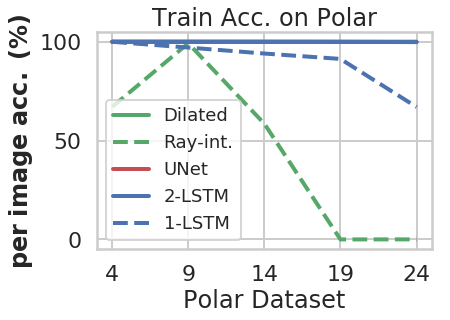

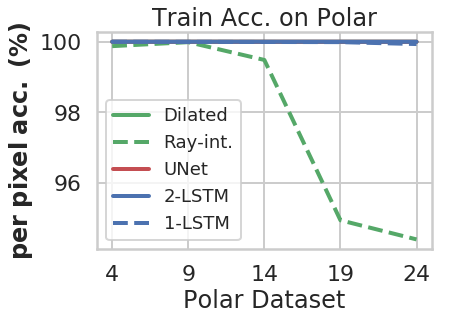

In [5]:
import seaborn

seaborn.set()
seaborn.set_style("whitegrid")
seaborn.set_context("poster")
def plot_results_train_test(train, title, fig, name,c):

    x = np.linspace(1,5, NUM_COMPLEXITIES)
    xlabels = ['4','9','14','19','24' ]
    ytext =r'$\bf per$ $\bf pixel$ $\bf acc.$ $\bf(\%)$'

    plt.figure(fig)
    print(train)
    plt.plot(x, train, c,label=name, linewidth=4)
    plt.ylabel(ytext)
    plt.xlabel('Polar Dataset')
    plt.title('Train Acc. on Polar')
    plt.xticks(x, xlabels)
    leg = plt.legend(loc='lower left', ncol=1,  fancybox=True, prop={'size': 18})
    plt.savefig('./fig/quantitative/train_1.pdf', format='pdf',  bbox_inches='tight', dpi=1000)

def plot_results_train_test_image(train, title, fig, name,c):

    x = np.linspace(1,5, NUM_COMPLEXITIES)
    xlabels = ['4','9','14','19','24' ]
    ytext =r'$\bf per$ $\bf image$ $\bf acc.$ $\bf(\%)$'

    plt.figure(fig)
    print(train)
    plt.plot(x, train, c,label=name, linewidth=4)
    plt.ylabel(ytext)
    plt.xlabel('Polar Dataset')
    plt.title('Train Acc. on Polar')
    plt.xticks(x, xlabels)
    leg = plt.legend(loc='lower left', ncol=1,  fancybox=True, prop={'size': 18})
    plt.savefig('./fig/quantitative/train_2.pdf', format='pdf',  bbox_inches='tight', dpi=1000)

plot_results_train_test_image(100*max_train[0][0,:], "Exclusive Complexity", 1, 'Dilated', 'g')
plot_results_train_test_image(100*max_train[1][0,:], "Exclusive Complexity", 1, 'Ray-int.', 'g--')
plot_results_train_test_image(100*max_train[4][0,:], "Exclusive Complexity", 1, 'UNet', 'r')
plot_results_train_test_image(100*max_train[2][0,:], "Exclusive Complexity", 1, '2-LSTM', 'b')
plot_results_train_test_image(100*max_train[3][0,:], "Exclusive Complexity", 1, '1-LSTM', 'b--')


plot_results_train_test(100*max_train_loose[0][0,:], "Loose Acc - Exclusive Complexity", 2, 'Dilated', 'g')
plot_results_train_test(100*max_train_loose[1][0,:], "Loose Acc - Exclusive Complexity", 2, 'Ray-int.','g--')
plot_results_train_test(100*max_train_loose[4][0,:], "Exclusive Complexity", 2, 'UNet','r')
plot_results_train_test(100*max_train_loose[2][0,:], "Exclusive Complexity", 2, '2-LSTM', 'b')
plot_results_train_test(100*max_train_loose[3][0,:], "Exclusive Complexity", 2, '1-LSTM', 'b--')




In [6]:
NET = 'multi_lstm_init'

if NET == 'dilation':
    import experiments.dilation as experiments
elif NET == 'segnet':
    import experiments.segnet as experiments
elif NET == 'lstm':
    import experiments.lstm as experiments
elif NET == 'coloring':
    import experiments.coloring as experiments
elif NET == 'crossing':
    import experiments.crossing as experiments
elif NET == 'unet':
    import experiments.unet as experiments
elif NET == 'multi_lstm':
    import experiments.multi_lstm as experiments
elif NET == 'multi_lstm_init':
    import experiments.multi_lstm_init as experiments
elif NET == 'FF':
    import experiments.FF as experiments
elif NET == 'optimal_lstm':
    import experiments.optimal_lstm as experiments

output_path = '/om/user/xboix/share/insideness/' + NET + '/'
run_opt = experiments.get_best_of_the_family(output_path)
opt_data = datasets.get_datasets(output_path)

NUM_COMPLEXITIES = 5
results_data_generalization = []
for opt in run_opt:
    data_point = {}
        
    if NET == 'multi_lstm_init' and not opt.dataset.complexity==4:
        opt.dataset.complexity_strict = True
            
    if opt.dataset.complexity>4:
        continue
    if opt.dataset.complexity_strict == False:
        continue
        
    data_point["dataset_complexity"] = opt.dataset.complexity
    data_point["dataset_strict_complexity"] = opt.dataset.complexity_strict
        
    if not os.path.isfile(opt.log_dir_base + opt.name + '/results/generalization_accuracy.pkl'):
        data_point["results"] = "empty"
        print('EMPTY')
    else:
        with open(opt.log_dir_base + opt.name + '/results/generalization_accuracy.pkl', 'rb') as f:
            data_point["results"] = pickle.load(f)
            
    results_data_generalization.append(copy.deepcopy(data_point))
    
datasets_idx = np.zeros([2,NUM_COMPLEXITIES])
for idx, opt in enumerate(opt_data):
    if not opt.num_images_training == 1e5:
        continue
    if opt.complexity>4:
        continue
    if opt.complexity_strict:
        datasets_idx[0,opt.complexity] = idx
    else:
        datasets_idx[1,opt.complexity] = idx

{0: {'ID': 0, 'valloose': 1.0, 'train': 1.0, 'val': 1.0, 'trainloose': 1.0, 'test': 1.0, 'testloose': 1.0}, 1: {'ID': 14, 'valloose': 1.0, 'train': 1.0, 'val': 1.0, 'trainloose': 1.0, 'test': 1.0, 'testloose': 1.0}, 2: {'ID': 68, 'valloose': 0.9999998794657167, 'train': 0.9997684405523746, 'val': 0.9998000168406871, 'trainloose': 0.9999998563987793, 'test': 0.9995053048164365, 'testloose': 0.9999996321134673}, 3: {'ID': 98, 'valloose': 0.9999995045125505, 'train': 0.9998000168406871, 'val': 0.9992000673627484, 'trainloose': 0.9999998745672548, 'test': 0.9997894914112496, 'testloose': 0.9999998650915416}, 4: {'ID': 121, 'valloose': 0.9999996414486508, 'train': 0.9995263556753116, 'val': 0.9994000505220613, 'trainloose': 0.9999996795723357, 'test': 0.9993263725159987, 'testloose': 0.9999935731176336}, 5: {'ID': 176, 'valloose': 0.9999985112490257, 'train': 0.998989558773998, 'val': 0.9990000842034354, 'trainloose': 0.9999991415044039, 'test': 0.9987895756146851, 'testloose': 0.9999984714

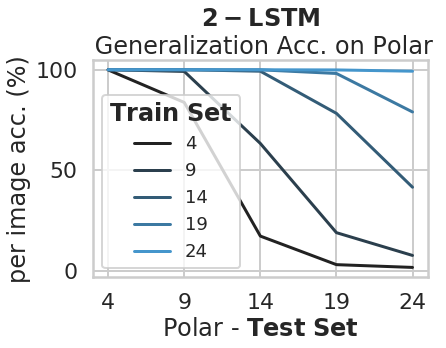

In [15]:

dataset_labels = ['4','9','14','19','24']
#fontbf = FontProperties()
#fontbf.set_weight('bold')

if NET == 'dilation':
    cc = itertools.cycle(sns.dark_palette((122, 90, 70), input="husl"))
    NET = "Dilated"
if NET == 'multi_lstm_init':
    cc = itertools.cycle(sns.dark_palette((240, 90, 70), input="husl"))
    NET = "2-LSTM"
if NET == 'UNet':
    cc = itertools.cycle(sns.dark_palette((5, 70, 70), input="husl"))
    NET = "UNet"
    
def plot_results_generalization(train, title, fig, name):
    x = np.linspace(1,NUM_COMPLEXITIES, NUM_COMPLEXITIES)
    xlabels = dataset_labels
    ytext = 'per image acc. (%)'
    xtext = r'Polar - $\bf Test$ $\bf Set$'
    
    plt.figure(fig)
    #print(train)
    plt.plot(x, train, label=name, color=next(cc))
    plt.title(title)
    plt.ylabel(ytext)
    plt.xticks(x, xlabels)
    plt.xlabel(xtext)
    leg = plt.legend(loc='lower left', ncol=1,  title=r'$\bf Train$ $\bf Set$', fancybox=True, prop={'size': 18})
    plt.savefig('./fig/quantitative/' + NET +'.pdf', format='pdf',  bbox_inches='tight', dpi=1000)

for res in results_data_generalization:
    
    #Collect all generalization results for one network
    test = np.zeros([2, NUM_COMPLEXITIES])
    test_loose = np.zeros([2, NUM_COMPLEXITIES])
    for idx_strict, dataset_strict_complexity  in enumerate([True, False]):
        for dataset_complexity in range(NUM_COMPLEXITIES):
            if not int(datasets_idx[idx_strict,dataset_complexity])==0:
                test[idx_strict, dataset_complexity] = \
                    res["results"]["test_accuracy"][int(datasets_idx[idx_strict,dataset_complexity])]
                test_loose[idx_strict, dataset_complexity] = \
                    res["results"]["test_accuracy_loose"][int(datasets_idx[idx_strict,dataset_complexity])]

    plot_results_generalization(100*test[0,:], r"$\bf " + NET+"$\n Generalization Acc. on Polar", 0, dataset_labels[res['dataset_complexity']])

        